**To ensure reproducibility, a fixed random seed was used.**

In [ ]:
import tensorflow as tf
import numpy as np
import random

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

**🐟 Multiclass Fish Image Classification**

📌 **Project Overview**

This project focuses on classifying fish images into 11 categories using deep learning techniques. A custom CNN model was trained and compared with transfer learning models such as EfficientNetB0. The best performing model was deployed using streamlit.

**🎯 Problem Statement**

To build a deep learning model capable of accurately classifying fish images into multiple categories and deploy the model as a web application for real time predictions.

📂 **Dataset Overview**

- 11 Fish Classes
- Training Images: 6225
- Validation Images: 1092
- Test Images: 3187
- Data organized into train, val, test folders

In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/Dataset.zip"
extract_path = "/content/data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset Extracted Successfully!")

Dataset Extracted Successfully!


In [ ]:
train_path = "/content/data/images.cv_jzk6llhf18tm3k0kyttxz/data/train"

classes = os.listdir(train_path)
print("Number of classes:", len(classes))
print("Classes:", classes)

Number of classes: 11
Classes: ['fish sea_food trout', 'fish sea_food hourse_mackerel', 'fish sea_food sea_bass', 'fish sea_food red_mullet', 'fish sea_food striped_red_mullet', 'animal fish bass', 'fish sea_food gilt_head_bream', 'fish sea_food red_sea_bream', 'fish sea_food shrimp', 'animal fish', 'fish sea_food black_sea_sprat']


In [ ]:
for class_name in classes:
  class_path = os.path.join(train_path, class_name)
  print(class_name, ":", len(os.listdir(class_path)))

fish sea_food trout : 580
fish sea_food hourse_mackerel : 573
fish sea_food sea_bass : 538
fish sea_food red_mullet : 579
fish sea_food striped_red_mullet : 547
animal fish bass : 30
fish sea_food gilt_head_bream : 566
fish sea_food red_sea_bream : 571
fish sea_food shrimp : 576
animal fish : 1096
fish sea_food black_sea_sprat : 569


**🧹 Data Preprocessing**

- Rescaled images
- Applied augmentation
- Handled class imbalance using class weights

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.2
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "/content/data/images.cv_jzk6llhf18tm3k0kyttxz/data/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    "/content/data/images.cv_jzk6llhf18tm3k0kyttxz/data/val",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    "/content/data/images.cv_jzk6llhf18tm3k0kyttxz/data/test",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(0.5163404114134041), 1: np.float64(18.863636363636363), 2: np.float64(0.9945678223358364), 3: np.float64(0.9998393832316094), 4: np.float64(0.9876249405045217), 5: np.float64(0.9773904851625059), 6: np.float64(0.9910842222576023), 7: np.float64(1.0518756336600203), 8: np.float64(0.9824810606060606), 9: np.float64(1.0345687219544624), 10: np.float64(0.975705329153605)}


**🧠 CNN Model (From Scratch)**

A baseline CNN was trained to evaluate performance without transfer learning.

In [ ]:
# Build CNN Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(12, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(11, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train Model

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    class_weight=class_weights,
    callbacks=[early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 89s 419ms/step - accuracy: 0.2068 - loss: 2.3586 - val_accuracy: 0.3068 - val_loss: 2.0912
Epoch 2/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 76s 388ms/step - accuracy: 0.3359 - loss: 2.0316 - val_accuracy: 0.3489 - val_loss: 1.7963
Epoch 3/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 394ms/step - accuracy: 0.3651 - loss: 1.7634 - val_accuracy: 0.4286 - val_loss: 1.4535
Epoch 4/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 393ms/step - accuracy: 0.4348 - loss: 1.5796 - val_accuracy: 0.4734 - val_loss: 1.3873
Epoch 5/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 75s 384ms/step - accuracy: 0.4686 - loss: 1.4332 - val_accuracy: 0.6438 - val_loss: 1.0541
Epoch 6/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.5191 - loss: 1.3039 - val_accuracy: 0.6612 - val_loss: 0.9166
Epoch 7/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 76s 389ms/step - accuracy: 0.5941 - loss: 1.0567 - val_accuracy: 0.6658 - val_loss: 0.9243
Epoch 8/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 76s 386ms/step - accuracy: 0.6367 - loss: 0

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)

100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.8528 - loss: 0.4275
Test Accuracy: 0.8766865134239197


In [ ]:
# Train Pretrained Model (MobileNet)

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(11, activation='softmax')(x)

model_transfer = Model(inputs=base_model.input, outputs=output)

model_transfer.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
history_transfer = model_transfer.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 140s 570ms/step - accuracy: 0.0807 - loss: 2.5837 - val_accuracy: 0.0824 - val_loss: 2.3902
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.1085 - loss: 2.3617 - val_accuracy: 0.0897 - val_loss: 2.3985
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 76s 391ms/step - accuracy: 0.0928 - loss: 2.3462 - val_accuracy: 0.0897 - val_loss: 2.3985
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 76s 389ms/step - accuracy: 0.0555 - loss: 2.3935 - val_accuracy: 0.1712 - val_loss: 2.3973


**🚀 Transfer Learning - EfficientNetB0**

**📊 EfficientNet Results**

- Validation Accuracy: 99%
- Test Accuracy: 99.46%

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input

In [ ]:
train_datagen_eff = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.2
)

val_test_datagen_eff = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator_eff = train_datagen_eff.flow_from_directory(
    "/content/data/images.cv_jzk6llhf18tm3k0kyttxz/data/train",
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

val_generator_eff = val_test_datagen_eff.flow_from_directory(
    "/content/data/images.cv_jzk6llhf18tm3k0kyttxz/data/val",
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

test_generator_eff = val_test_datagen_eff.flow_from_directory(
    "/content/data/images.cv_jzk6llhf18tm3k0kyttxz/data/test",
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.


In [ ]:
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

In [ ]:
history_transfer = model_transfer.fit(
    train_generator_eff,
    validation_data=val_generator_eff,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 397ms/step - accuracy: 0.7458 - loss: 0.9976 - val_accuracy: 0.9789 - val_loss: 0.0927
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 76s 389ms/step - accuracy: 0.9494 - loss: 0.1620 - val_accuracy: 0.9963 - val_loss: 0.0246
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 76s 386ms/step - accuracy: 0.9582 - loss: 0.4605 - val_accuracy: 0.9945 - val_loss: 0.0316
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 76s 391ms/step - accuracy: 0.9732 - loss: 0.0818 - val_accuracy: 0.9918 - val_loss: 0.0328
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 75s 383ms/step - accuracy: 0.9792 - loss: 0.0548 - val_accuracy: 0.9844 - val_loss: 0.0659


In [ ]:
test_loss, test_acc = model_transfer.evaluate(test_generator_eff)
print("Test Accuracy:", test_acc)

100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 164ms/step - accuracy: 0.9886 - loss: 0.0521
Test Accuracy: 0.994665801525116


In [ ]:
model_transfer.save("best_fish_model.h5")

**📈 Model Comparison**

EfficientNet significantly outperformed the custom CNN.

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

predictions = model_transfer.predict(test_generator_eff)
y_pred = np.argmax(predictions, axis=1)

print(classification_report(test_generator_eff.classes, y_pred))

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       520
           1       0.53      0.77      0.62        13
           2       1.00      1.00      1.00       298
           3       1.00      1.00      1.00       305
           4       1.00      1.00      1.00       286
           5       1.00      1.00      1.00       291
           6       1.00      1.00      1.00       273
           7       1.00      1.00      1.00       327
           8       1.00      1.00      1.00       289
           9       1.00      1.00      1.00       293
          10       1.00      0.99      0.99       292

    accuracy                           0.99      3187
   macro avg       0.96      0.98      0.96      3187
weighted avg       1.00      0.99      1.00      3187



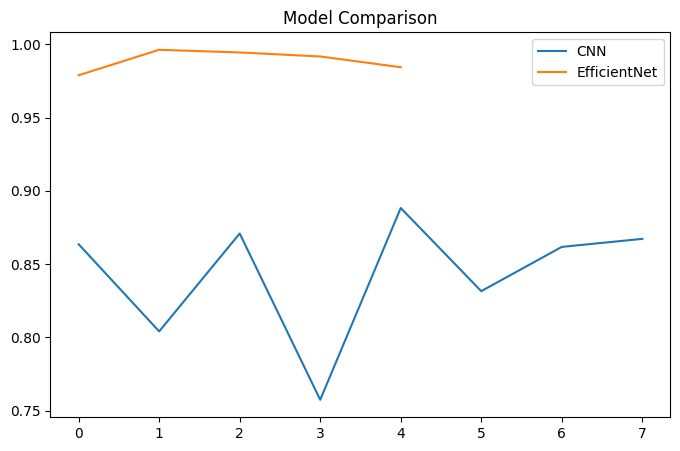

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['val_accuracy'], label='CNN')
plt.plot(history_transfer.history['val_accuracy'], label='EfficientNet')
plt.legend()
plt.title("Model Comparison")
plt.show()

In [ ]:
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image
from tensorflow.keras.applications.efficientnet import preprocess_input

model = tf.keras.models.load_model("best_fish_model.h5")

class_name =[
    'fish sea_food shrimp',
    'fish sea_food red_mullet',
    'fish sea_food hourse_mackerel',
    'fish sea_food trout',
    'fish sea_food sea_bass',
    'fish sea_food red_sea_bream',
    'animal fish',
    'fish sea_food black_sea_sprat',
    'fish sea_food striped_red_mullet',
    'fish sea_food gilt_head_bream',
    'animal fish bass'
]

st.title("🐟 Fish Image Classification App")
st.write("Upload a fish image to predict its category.")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "png", "jpeg"])

if uploaded_file is not None:
  image = Image.open(uploaded_file)
  st.image(image, caption="Uploaded Image", use_column_width=True)

  image = image.resize((224, 224))
  img_array = np.array(image)
  img_array = np.expand_dims(img_array, axis=0)
  img_array = preprocess_input(img_array)

  prediction = model.predict(img_array)
  predicted_class = class_names[np.argmax(prediction)]
  confidence = np.max(prediction)

  st.sucess(f"prediction: {predicted_class}")
  st_write(f"Confidence: {confidense:.2f}")


2026-02-12 19:00:13.969 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-12 19:00:15.109 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2026-02-12 19:00:15.117 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-12 19:00:15.119 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-12 19:00:15.120 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-12 19:00:15.125 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-12 19:00:15.125 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-12 19:00:15.129 Thread 'MainThread': mi

**Conclusion**

The baseline CNN achieved 87.67% test accuracy.
Transfer learning using EfficientNetB0 improved performance to 99.46%.
EfficientNetB0 outperformed the baseline CNN because it leverages pretrained ImageNet weights, allowing the model to utilize rich feature representations learned from large-scale datasets.